In [1]:
import time
import os

import pandas as pd
import numpy as np
np.set_printoptions(precision=6, suppress=True)

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import *
tf.__version__

'2.1.0'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

# Model training

## hyperparameters

In [6]:
SIZE = 50
BEST_PATH = './checkpoints/UNet_%dx%d' % (SIZE, SIZE)
DISP_STEPS = 100
TRAINING_EPOCHS = 500
BATCH_SIZE = 32
LEARNING_RATE = 0.001

## data loading

In [7]:
l = np.load('./data/tot_dataset_%dx%d.npz' % (SIZE, SIZE))
raw_input = l['raw_input']
raw_label = l['raw_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

SCREEN_SIZE = l['SCREEN_SIZE']

In [8]:
print(raw_input.shape)
print(raw_label.shape)

(134993, 50, 50, 4)
(134993, 50, 50, 1)


In [9]:
print(test_input.shape)
print(test_label.shape)

(78263, 50, 50, 4)
(78263, 50, 50, 1)


In [10]:
raw_input = raw_input.astype(np.float32)
raw_label = raw_label.astype(np.float32)
test_input = test_input.astype(np.float32)
test_label = test_label.astype(np.float32)

In [11]:
num_train = int(raw_input.shape[0]*.7)
raw_input, raw_label = shuffle(raw_input, raw_label, random_state=4574)
train_input, train_label = raw_input[:num_train, ...], raw_label[:num_train, ...]
val_input, val_label = raw_input[num_train:, ...], raw_label[num_train:, ...]

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_label))
val_dataset = val_dataset.cache().shuffle(BATCH_SIZE*50).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, dropout_rate):
        super(ConvBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        
        self.conv1 = layers.Conv2D(self.filters, self.kernel_size,
                                   activation='relu', kernel_initializer='he_normal', padding='same')
        self.batch1 = layers.BatchNormalization()
        self.drop = layers.Dropout(self.dropout_rate)
        self.conv2 = layers.Conv2D(self.filters, self.kernel_size,
                                   activation='relu', kernel_initializer='he_normal', padding='same')
        self.batch2 = layers.BatchNormalization()
        
    def call(self, inp):
        
        inp = self.batch1(self.conv1(inp))
        inp = self.drop(inp)
        inp = self.batch2(self.conv2(inp))
        
        return inp

In [14]:
class DeconvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides):
        super(DeconvBlock, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        
        self.deconv1 = layers.Conv2DTranspose(self.filters, self.kernel_size, strides=self.strides, padding='same')
        
    def call(self, inp):
        
        inp = self.deconv1(inp)
        
        return inp

In [15]:
class UNet(Model):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv_block1 = ConvBlock(32, (2, 2), 0.1)
        self.pool1 = layers.MaxPooling2D()
        
        self.conv_block2 = ConvBlock(256, (2, 2), 0.2)
        self.pool2 = layers.MaxPooling2D()
        
        self.conv_block3 = ConvBlock(512, (2, 2), 0.2)
        
        self.deconv_block1 = DeconvBlock(256, (2, 2), (2, 2))
        self.conv_block4 = ConvBlock(256, (2, 2), 0.2)
        
        self.deconv_block2 = DeconvBlock(64, (2, 2), (2, 2))
        self.padding = layers.ZeroPadding2D(((1, 0), (0, 1)))
        self.conv_block5 = ConvBlock(128, (2, 2), 0.1)
        
        self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')
        
    def call(self, inp):
        
        conv1 = self.conv_block1(inp)
        pooled1 = self.pool1(conv1)
        conv2 = self.conv_block2(pooled1)
        pooled2 = self.pool2(conv2)
        
        bottom = self.conv_block3(pooled2)
        
        deconv1 = self.padding(self.deconv_block1(bottom))
        deconv1 = layers.concatenate([deconv1, conv2])
        deconv1 = self.conv_block4(deconv1)
        deconv2 = self.deconv_block2(deconv1)
        deconv2 = layers.concatenate([deconv2, conv1])
        deconv2 = self.conv_block5(deconv2)
        
        return self.output_conv(deconv2)

In [16]:
#loss inputs should be masked.
loss_object = tf.keras.losses.MeanSquaredError()
def loss_function(model, inp, tar):
    
    masked_real = tar
    masked_pred = model(inp)
    
    return loss_object(masked_real, masked_pred)

In [17]:
unet_model = UNet()
opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [18]:
@tf.function
def train(loss_function, model, opt, inp, tar):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss_function(model, inp, tar), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [19]:
checkpoint_path = BEST_PATH

ckpt = tf.train.Checkpoint(unet_model=unet_model,
                           opt=opt)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [20]:
writer = tf.summary.create_file_writer('tmp')

# Training

In [21]:
prev_test_loss = 100.0
with writer.as_default():
    with tf.summary.record_if(True):
        for epoch in range(TRAINING_EPOCHS):
            for step, (inp, tar) in enumerate(train_dataset):
                train(loss_function, unet_model, opt, inp, tar)
                loss_values = loss_function(unet_model, inp, tar)
                tf.summary.scalar('loss', loss_values, step=step)
                
                if step % DISP_STEPS == 0:
                    test_loss = 0
                    for step_, (inp_, tar_) in enumerate(test_dataset):
                        test_loss += loss_function(unet_model, inp_, tar_)
                        
                        if step_ > DISP_STEPS:
                            test_loss /= DISP_STEPS
                            break
                    if test_loss.numpy() < prev_test_loss:
                        ckpt_save_path = ckpt_manager.save()
                        prev_test_loss = test_loss.numpy()
                        print('Saving checkpoint at {}'.format(ckpt_save_path))
                    print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                          .format(epoch, step, loss_values.numpy(), test_loss.numpy()))

Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-1
Epoch 0 batch 0 train loss: 0.1734 test loss: 0.2407
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-2
Epoch 0 batch 100 train loss: 0.0090 test loss: 0.0069
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-3
Epoch 0 batch 200 train loss: 0.0042 test loss: 0.0047
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-4
Epoch 0 batch 300 train loss: 0.0041 test loss: 0.0030
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-5
Epoch 0 batch 400 train loss: 0.0031 test loss: 0.0030
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-6
Epoch 0 batch 500 train loss: 0.0023 test loss: 0.0027
Epoch 0 batch 600 train loss: 0.0033 test loss: 0.0048
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-7
Epoch 0 batch 700 train loss: 0.0016 test loss: 0.0023
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-8
Epoch 0 batch 800 train loss: 0.0024 test loss: 0.0021
Saving checkpoint at ./checkpoints/UNet_50x50/ckpt-9
Epoch 0 batch 900 train loss: 

KeyboardInterrupt: 

# Model evaluation

In [22]:
i = -1
if ckpt_manager.checkpoints:
    ckpt.restore(ckpt_manager.checkpoints[i])
    print ('Checkpoint ' + ckpt_manager.checkpoints[i][-2:] +' restored!!')

Checkpoint 40 restored!!


In [23]:
unet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [24]:
test_loss = unet_model.evaluate(test_dataset)

2446/2446 [==============================] - 28s 11ms/step - loss: 0.0019


In [25]:
pred_result = unet_model.predict(test_dataset)

In [26]:
print(pred_result.shape)
print(test_label.shape)

(78263, 50, 50, 1)
(78263, 50, 50, 1)


In [27]:
avg_pred = []
OUTLIER = 1
for __ in range(5):
    temp = []
    for _ in range(int(pred_result.shape[1]/5)):
        temp.append(pred_result[..., _*5:(_+1)*5, 0][..., __])
    temp = np.stack(temp, axis=2)
    temp.sort(axis=2)
    avg_pred.append(temp[..., OUTLIER:-OUTLIER].mean(axis=2))
avg_pred = np.stack(avg_pred, axis=2)

In [28]:
masking = test_input[..., 1]
avg_masking = masking[..., :5]

In [29]:
masked_pred = np.ma.array(pred_result[..., 0], mask=masking)
masked_avg_pred = np.ma.array(avg_pred, mask=avg_masking)
masked_label = np.ma.array(test_label[..., 0], mask=masking)

In [30]:
for _ in range(5):
    print(np.sqrt(mean_squared_error(masked_label[..., _].reshape(-1), masked_pred[..., _].reshape(-1))))

0.04241646
0.040791474
0.05323703
0.028948871
0.051915336


In [31]:
for _ in range(5):
    print(np.sqrt(mean_squared_error(masked_label[..., _].reshape(-1), masked_avg_pred[..., _].reshape(-1))))

0.04137901
0.037543338
0.048064336
0.023061978
0.0489001


In [32]:
r2 = RSquare()
for _ in range(5):
    r2.reset_states()
    print(r2(masked_label[..., _][~masked_label[..., _].mask].data.reshape(-1),
             masked_pred[..., _][~masked_pred[..., _].mask].data.reshape(-1)))

tf.Tensor(0.7694968, shape=(), dtype=float32)
tf.Tensor(0.8858325, shape=(), dtype=float32)
tf.Tensor(0.7156914, shape=(), dtype=float32)
tf.Tensor(0.39688742, shape=(), dtype=float32)
tf.Tensor(0.73084146, shape=(), dtype=float32)


In [33]:
for _ in range(5):
    r2.reset_states()
    print(r2(masked_label[..., _][~masked_label[..., _].mask].data.reshape(-1),
             masked_avg_pred[..., _][~masked_avg_pred[..., _].mask].data.reshape(-1)))

tf.Tensor(0.7808408, shape=(), dtype=float32)
tf.Tensor(0.9033197, shape=(), dtype=float32)
tf.Tensor(0.7685175, shape=(), dtype=float32)
tf.Tensor(0.6179595, shape=(), dtype=float32)
tf.Tensor(0.76116884, shape=(), dtype=float32)


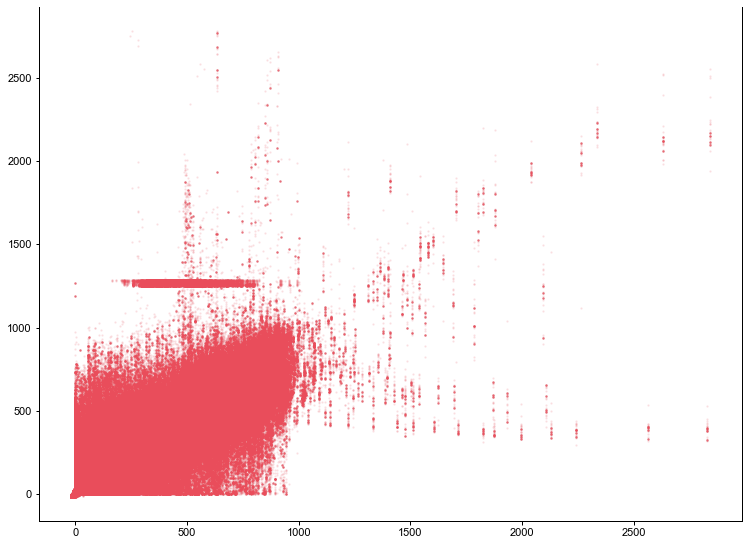

tf.Tensor(0.8751017, shape=(), dtype=float32)
79.10344922695977


In [34]:
plot_label = ((MAXS[:5]-MINS[:5])*masked_label[..., :5] + MINS[:5]).reshape(-1, 1)
plot_label = plot_label[~plot_label.mask]
plot_pred = ((MAXS[:5]-MINS[:5])*masked_pred[..., :5] + MINS[:5]).reshape(-1, 1)
plot_pred = plot_pred[~plot_pred.mask]
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))
plt.scatter(plot_label, plot_pred, c=cmap[0], s=2, alpha=0.1)
plt.show()

r2 = RSquare()
r2.reset_states()
print(r2(plot_label, plot_pred))
print(np.sqrt(mean_squared_error(plot_label, plot_pred)))

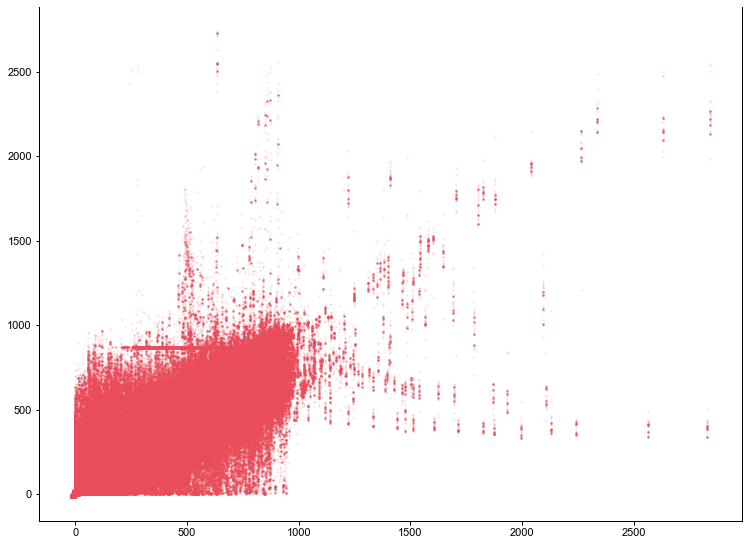

tf.Tensor(0.8751017, shape=(), dtype=float32)
68.98999777459261


In [35]:
plot_label = ((MAXS[:5]-MINS[:5])*masked_label[..., :5] + MINS[:5]).reshape(-1, 1)
plot_label = plot_label[~plot_label.mask]
plot_avg_pred = ((MAXS[:5]-MINS[:5])*masked_avg_pred[..., :5] + MINS[:5]).reshape(-1, 1)
plot_avg_pred = plot_avg_pred[~plot_avg_pred.mask]
fig = plt.figure(figsize=((8/2.54)*4, (6/2.54)*4))
plt.scatter(plot_label, plot_avg_pred, c=cmap[0], s=2, alpha=0.1)
plt.show()

r2 = RSquare()
r2.reset_states()
print(r2(plot_label, plot_pred))
print(np.sqrt(mean_squared_error(plot_label, plot_avg_pred)))

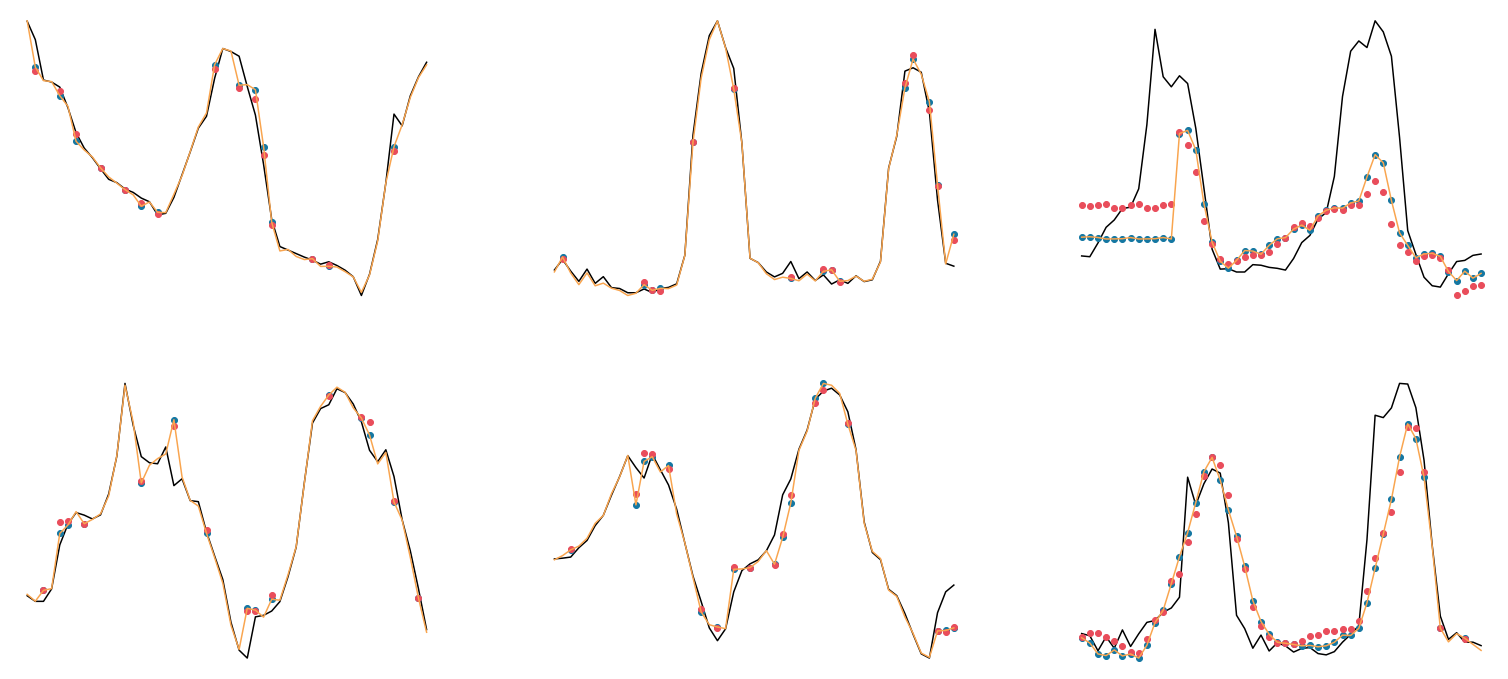

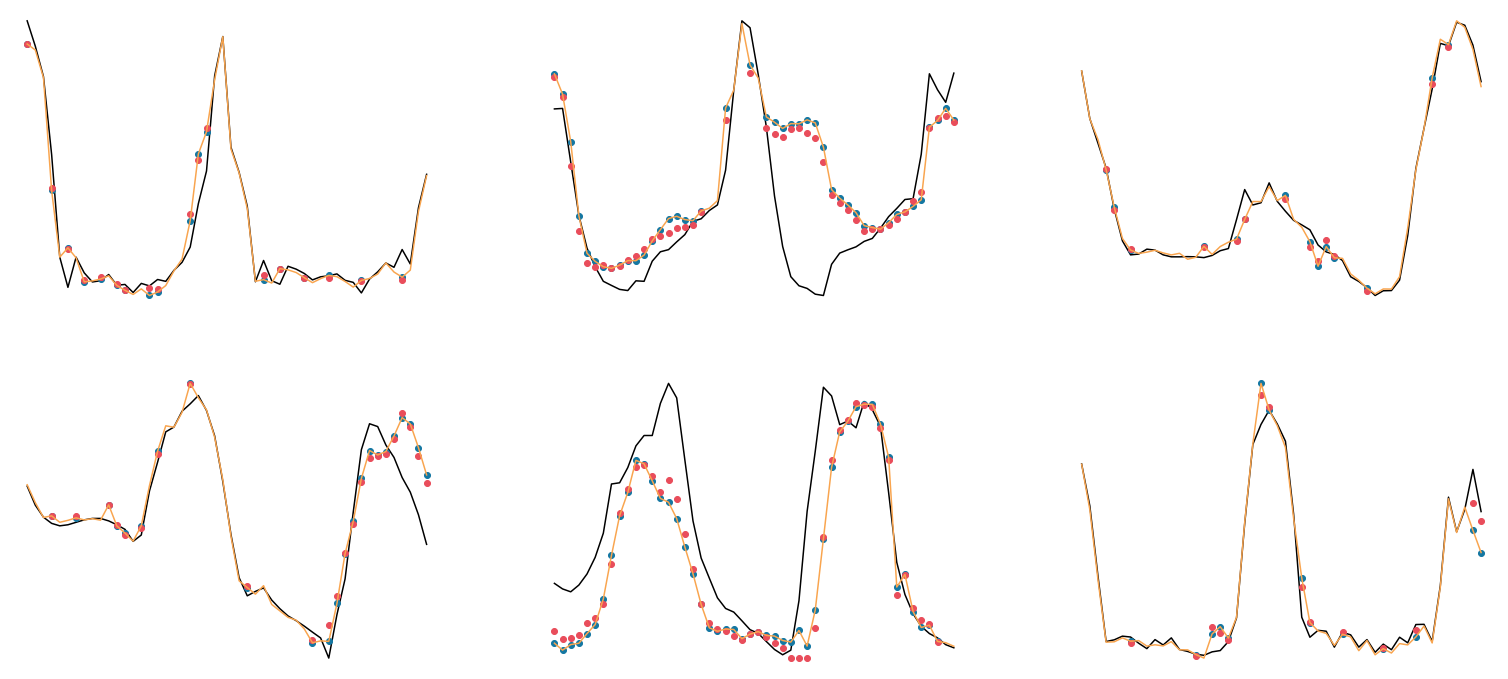

In [39]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (2):

        NUMBERS = np.arange(1, pred_result.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*8, (6/2.54)*8))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, masked_pred[NUMBER, :, i], 'o', c=cmap[5], alpha=1) #estimated
            expect1 = plt.plot(x_t, masked_avg_pred[NUMBER, :, i], 'o', c=cmap[0], alpha=1) #estimated
            expect2 = plt.plot(x_t, pred_result[NUMBER, :, i], c=cmap[2], alpha=1) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

# Saving data

In [37]:
plot_label = ((MAXS[:5]-MINS[:5])*masked_label[..., :5] + MINS[:5])
plot_label.fill_value = np.nan
plot_avg_pred = ((MAXS[:5]-MINS[:5])*masked_avg_pred[..., :5] + MINS[:5])
plot_avg_pred.fill_value = np.nan

In [38]:
f = open('./results/UNet_%sx%s_lossc.npz' % (SCREEN_SIZE, SCREEN_SIZE), 'wb')
np.savez(f,
         test_label = plot_label.filled(),
         test_pred = plot_avg_pred.filled()
        )
f.close()